In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq "/content/drive/MyDrive/artificial_control/data2.zip" -d "/content/drive/MyDrive/artificial_control/data2/"

In [ ]:
import importlib
import os
import random
import fnmatch
import datetime
import pickle

import numpy as np
np.set_printoptions(formatter={'float_kind' : lambda x : "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print(f'tf.__version__: {tf.__version__}')
print(f'.keras.__version__: {tensorflow.keras.__version__}')

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.9.2
.keras.__version__: 2.9.0


image_path : /content/drive/MyDrive/artificial_control/data2/data2/train_4_00243_135.png
steering_Angle : 135


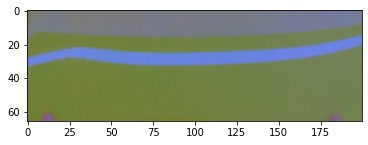

In [ ]:
data_dir = "/content/drive/MyDrive/artificial_control/data2/data2"
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir,filename))
    angle = int(filename[-7:-4])
    steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path : %s" % image_paths[image_index])
print("steering_Angle : %d" % steering_angles[image_index])
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([2880.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 9083.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        3367.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <a list of 25 Patch objects>)

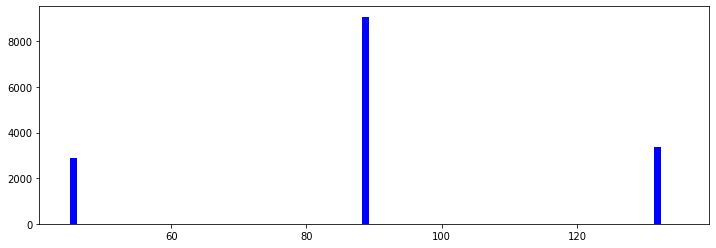

In [ ]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize = (12, 4))
axes.hist(df['Angle'], bins = num_of_bins, width = 1, color = 'blue')

Training data : 12264
Validation data : 3066


Text(0.5, 1.0, 'Validation Data')

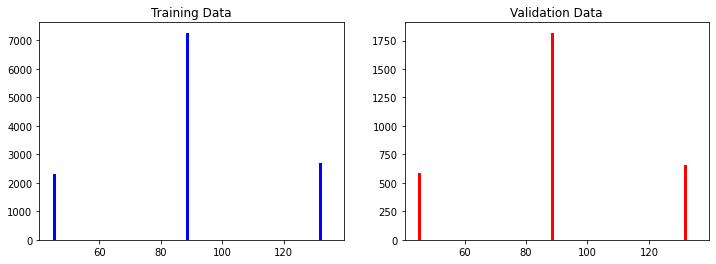

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size = 0.2)
print("Training data : %d\nValidation data : %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize = (12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color = 'blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins = num_of_bins, width = 1, color = 'red')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'processed')

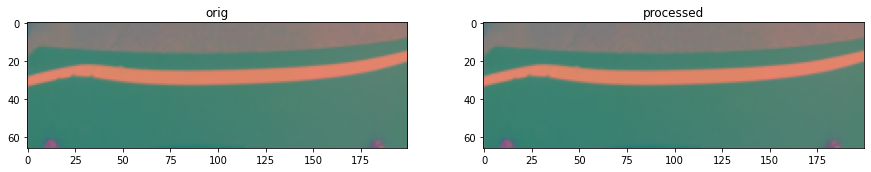

In [ ]:
def my_imread(image_path):
  image = cv2.imread(image_path)
  return image

def img_preprocess(image):
  image = image / 255
  return image

fig, axes = plt.subplots(1, 2, figsize=(15,10))
image_orig = my_imread(image_paths[image_index])

#for i in range(3):
 # augmented_image = data_augmentation(image_orig)

image_processed = img_preprocess(image_orig)

axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

### NVIDIA_MODEL

In [ ]:
def nvidia_model():
    model = Sequential(name = 'Nvidia_Model')

    model.add(Conv2D(24, (5,5), strides = (2,2), input_shape = (66, 200, 3), activation = 'elu'))
    model.add(Conv2D(36, (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(48, (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(64, (3,3), activation = 'elu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation = 'elu'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))

    model.add(Dense(1))
    
    optimizer = Adam(lr = 1e-3)
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

model = nvidia_model()
print(model.summary())


### RESNET

In [ ]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
def ResNet50(input_shape = (66, 200, 3), classes = 1):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = tf.keras.layers.Conv2D(64, (3,3), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = convolutional_block(X, 64, (3,3)) 
    X = identity_block(X, 64, (3,3))
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) 
    X = identity_block(X, 128, (3,3))
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3))
    X = identity_block(X, 512, (3,3))
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(1, activation = 'softmax')(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50")
    
    return model

In [ ]:
model = ResNet50()
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 66, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_129 (Conv2D)            (None, 66, 200, 64)  1792        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_129 (Batch  (None, 66, 200, 64)  256        ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                           

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

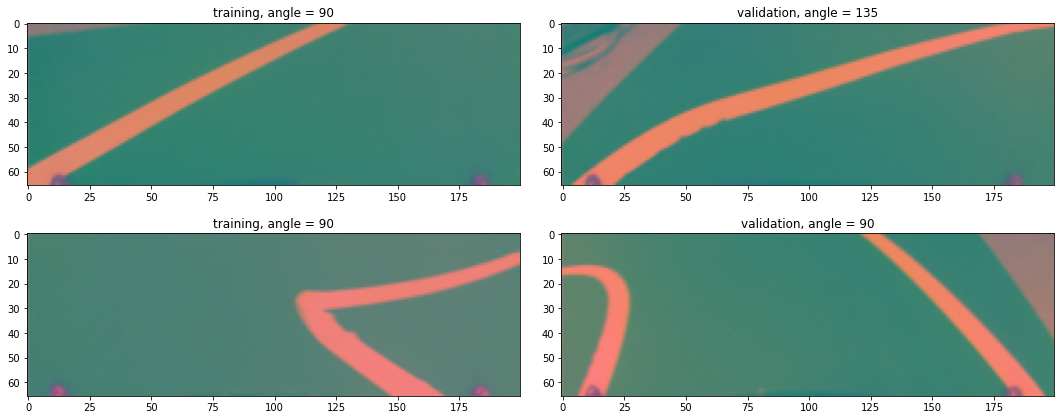

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size):
  while True:
    batch_images = []
    batch_streering_angles = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      image_path = image_paths[random_index]
      image = my_imread(image_paths[random_index])
      steering_angle = steering_angles[random_index]

      image = img_preprocess(image)
      batch_images.append(image)
      batch_streering_angles.append(steering_angle)
    
    yield(np.asarray(batch_images), np.asarray(batch_streering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize = (15,6))
fig.tight_layout()

for i in range(nrow):
  axes[i][0].imshow(X_train_batch[i])
  axes[i][0].set_title("training, angle = %s" % y_train_batch[i])
  axes[i][1].imshow(X_valid_batch[i])
  axes[i][1].set_title("validation, angle = %s" % y_valid_batch[i])                                                            

In [ ]:
  model_output_dir = "/content/drive/MyDrive/artificial_control/model"

  checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'lane_navigation_check.h5'), 
                                                                 verbose=1, save_best_only =True)

  history = model.fit(image_data_generator(X_train, y_train, batch_size=80), steps_per_epoch=300, epochs=25, 
                                                   validation_data=image_data_generator(X_valid, y_valid, batch_size=100),
                                                   validation_steps=200, verbose=1, shuffle=1, callbacks = [checkpoint_callback])

  model.save(os.path.join(model_output_dir, 'lane_navigation_final_2.h5'))

  history_path = os.path.join(model_output_dir, 'history.pickle')

  with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/25


KeyboardInterrupt: ignored

In [ ]:
history.history

history_path = os.path.join(model_output_dir, 'history.pickle')

with open(history_path, 'rb') as f:
  history = pickle.load(f)


history
plt.plot(history['loss'], color = 'blue')
plt.plot(history['val_loss'], color = 'red')
plt.legend(['training loss', 'validation loss'])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
  mse = mean_squared_error(Y_true, Y_pred)
  r_squared = r2_score(Y_true, Y_pred)

  print(f'mse = {mse:.2}')
  print(f'r_squared = {r_squared:.2%}')
  print()

def predict_and_summarize(X, Y):
  model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
  Y_pred = model.predict(X)
  summarize_prediction(Y, Y_pred)
  return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 3
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10,4 * n_tests_show))
for i in range(n_tests_show):
  axes[i].imshow(X_test[i])
  axes[i].set_title(f"actual angle = {y_test[i]}, predicted angle = {int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")